In [73]:
from fastbook import *
from fastai.tabular.all import *
from kaggle import api

In [16]:
path = URLs.path('bluebook')
path

Path('/Users/koichiro.mori/.fastai/archive/bluebook')

In [19]:
api.competition_download_cli('bluebook-for-bulldozers', path=path)
file_extract(path / 'bluebook-for-bulldozers.zip')

bluebook-for-bulldozers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
path.ls(file_type='text')

(#7) [Path('/Users/koichiro.mori/.fastai/archive/bluebook/random_forest_benchmark_test.csv'),Path('/Users/koichiro.mori/.fastai/archive/bluebook/Valid.csv'),Path('/Users/koichiro.mori/.fastai/archive/bluebook/median_benchmark.csv'),Path('/Users/koichiro.mori/.fastai/archive/bluebook/Test.csv'),Path('/Users/koichiro.mori/.fastai/archive/bluebook/ValidSolution.csv'),Path('/Users/koichiro.mori/.fastai/archive/bluebook/Machine_Appendix.csv'),Path('/Users/koichiro.mori/.fastai/archive/bluebook/TrainAndValid.csv')]

In [39]:
df = pd.read_csv(path / 'TrainAndValid.csv', low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [41]:
# ordinal
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [42]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [43]:
df['ProductSize']

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [44]:
dep_var = 'SalePrice'  # 予測対象の属性

In [45]:
df[dep_var] = np.log(df[dep_var])

In [46]:
df[dep_var]

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
412693     9.210340
412694     9.259131
412695     9.433484
412696     9.210340
412697     9.472705
Name: SalePrice, Length: 412698, dtype: float64

In [47]:
df['saledate']

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

In [48]:
# 日付から新しい属性（日付、曜日など）を生成する
df = add_datepart(df, 'saledate')
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1.163635e+09
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1.080259e+09
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1.077754e+09
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1.305763e+09
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1.248307e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,9.210340,1919201,21435,149,2.0,2005,NaN,NaN,30NX,...,7,2,67,False,False,False,False,False,False,1.331078e+09
412694,6333345,9.259131,1882122,21436,149,2.0,2005,NaN,NaN,30NX2,...,28,5,28,False,False,False,False,False,False,1.327709e+09
412695,6333347,9.433484,1944213,21435,149,2.0,2005,NaN,NaN,30NX,...,28,5,28,False,False,False,False,False,False,1.327709e+09
412696,6333348,9.210340,1794518,21435,149,2.0,2006,NaN,NaN,30NX,...,7,2,67,False,False,False,False,False,False,1.331078e+09


In [49]:
df_test = pd.read_csv(path / 'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1227829,1006309,3168,121,3,1999,3688.0,Low,580G,580,...,3,3,124,False,False,False,False,False,False,1.336003e+09
1,1227844,1022817,7271,121,3,1000,28555.0,High,936,936,...,10,3,131,False,False,False,False,False,False,1.336608e+09
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,EC210BLC,EC210,...,10,3,131,False,False,False,False,False,False,1.336608e+09
3,1227848,56204,1269,121,3,2006,8940.0,High,330CL,330,...,10,3,131,False,False,False,False,False,False,1.336608e+09
4,1227863,1053887,22312,121,3,2005,2286.0,Low,650K,650,...,10,3,131,False,False,False,False,False,False,1.336608e+09


In [50]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [51]:
procs = [Categorify, FillMissing]

In [53]:
cond = (df.saleYear < 2011) | (df.saleMonth < 10)
train_idx = np.where(cond)[0]
valid_idx = np.where(-cond)[0]

In [56]:
len(train_idx), len(valid_idx)

(404710, 7988)

In [59]:
splits = (list(train_idx), list(valid_idx))

In [60]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [61]:
cont

['SalesID',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'saleYear',
 'saleMonth',
 'saleWeek',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleElapsed']

In [62]:
cat

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start']

In [63]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [66]:
to

        SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
0       1139246  11.097410     999089     3157         121           3.0   
1       1139248  10.950807     117657       77         121           3.0   
2       1139249   9.210340     434808     7009         121           3.0   
3       1139251  10.558414    1026470      332         121           3.0   
4       1139253   9.305651    1057373    17311         121           3.0   
...         ...        ...        ...      ...         ...           ...   
401120  6333336   9.259130    1840702    21439         149           1.0   
401121  6333337   9.305651    1830472    21439         149           1.0   
401122  6333338   9.350102    1887659    21439         149           1.0   
401123  6333341   9.104980    1903570    21435         149           2.0   
401124  6333342   8.955448    1926965    21435         149           2.0   

        YearMade  MachineHoursCurrentMeter  UsageBand  fiModelDesc  ...  \
0           

In [67]:
len(to.train), len(to.valid)

(404710, 7988)

In [68]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [69]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,...,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,...,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,...,57,1,1,1,1,1,1,1.077754e+09,1,1


In [70]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [75]:
save_pickle(path / 'to.pkl', to)

In [104]:
to = load_pickle(path / 'to.pkl')

In [105]:
xs, y = to.train.xs, to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
xs.shape, y.shape

((404710, 66), (404710,))

In [106]:
from sklearn.tree import DecisionTreeRegressor
# leafノードが4つになるまで分割する
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

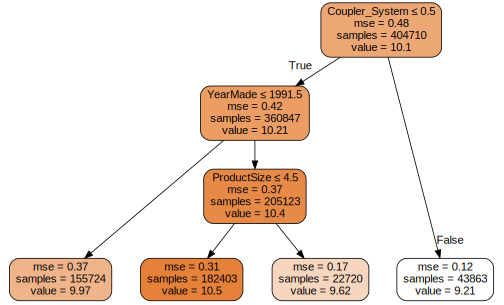

In [107]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

In [108]:
samp_idx = np.random.permutation(len(y))[:500]
samp_idx.shape

(500,)

In [109]:
from dtreeviz.trees import *

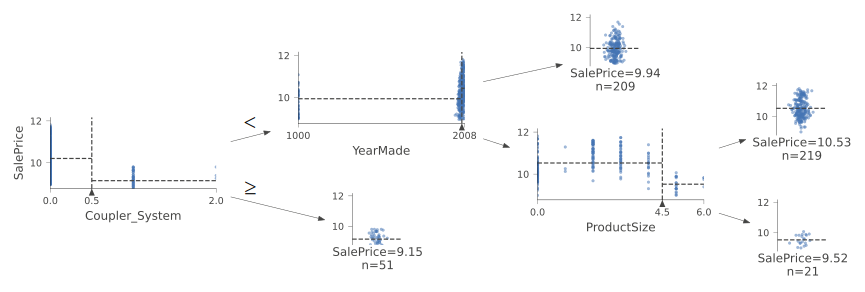

In [110]:
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, fontname='DejaVu Sans', scale=1.6, label_fontsize=10, orientation='LR')

In [111]:
xs.loc[xs['YearMade'] < 1900, 'YearMade'] = 1950

In [112]:
valid_xs.loc[valid_xs['YearMade'] < 1900, 'YearMade'] = 1950

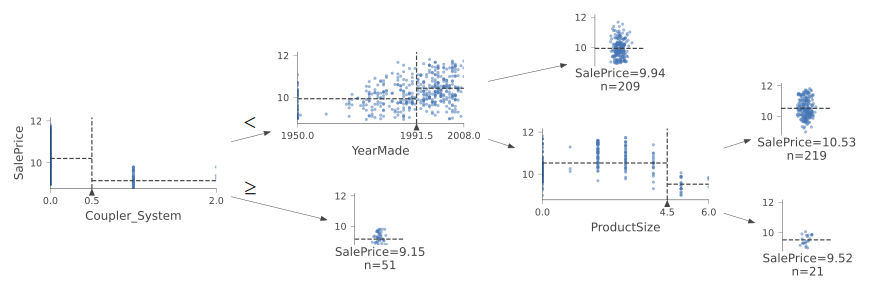

In [113]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, fontname='DejaVu Sans', scale=1.6, label_fontsize=10, orientation='LR')

In [114]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [124]:
def r_mse(pred, y):
    return round(math.sqrt(((pred - y) ** 2).mean()), 6)

def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

In [125]:
m_rmse(m, xs, y)

0.0

In [126]:
m_rmse(m, valid_xs, valid_y)

0.333761

In [127]:
m.get_n_leaves(), len(xs)

(324573, 404710)

In [128]:
# leafノードのサンプル数が25個になるまで分割する
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)

DecisionTreeRegressor(min_samples_leaf=25)

In [130]:
m_rmse(m, xs, y)

0.248595

In [131]:
m_rmse(m, valid_xs, valid_y)

0.323348

In [132]:
m.get_n_leaves()

12397

## Random Forest

In [133]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [148]:
m = rf(xs, y)

In [149]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171163, 0.2324)

In [150]:
len(m.estimators_)

40

In [151]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

(40, 7988)

In [152]:
preds.mean(0).shape

(7988,)

In [153]:
r_mse(preds.mean(0), valid_y)

0.2324

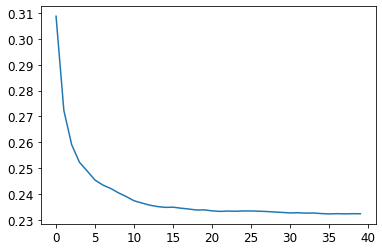

In [154]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

In [155]:
r_mse(m.oob_prediction_, y)

0.210957